In [3]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
file_path = '/content/drive/MyDrive/Colab_Notebooks/Kaggle_Competition/Titanic - Machine Learning from Disaster/'

Mounted at /content/drive


In [40]:
file_name = ['train.csv', 'test.csv']
file_names = []
for name in file_name:
  file_names.append([name, pd.read_csv(file_path + name)])


In [41]:
for i, [name, df] in enumerate(file_names):
  print('★',name)
  print(df.columns)

  try:
    df.drop(columns=['Name','Cabin'], inplace=True)
  except:
    None

  df[df.isnull().any(axis=1)]
  df[['Age']] = df[['Age']].fillna(0)

  mean = df['Fare'].mean()
  df[['Fare']] = df[['Fare']].fillna(mean)
  print(df.isnull().sum())

  df.dropna(inplace=True)
  print(df.isnull().sum())
  #print(name, df.head())

★ train.csv
Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')
PassengerId    0
Survived       0
Pclass         0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       2
dtype: int64
PassengerId    0
Survived       0
Pclass         0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
dtype: int64
★ test.csv
Index(['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch',
       'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')
PassengerId    0
Pclass         0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
dtype: int64
PassengerId    0
Pclass         0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       

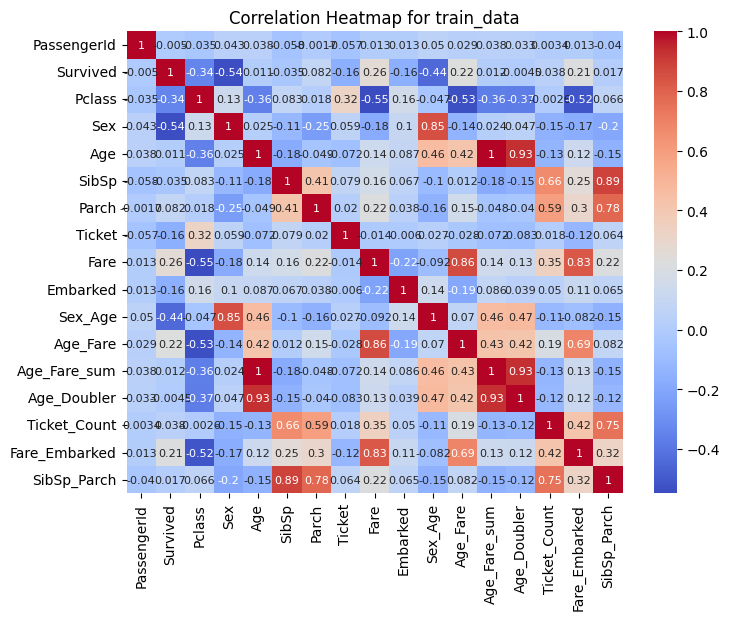

In [45]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

train_data = file_names[0][1].copy()

# text to label
Sex_encoder = LabelEncoder()
train_data['Sex'] = Sex_encoder.fit_transform(train_data['Sex'])
Embarked_encoder = LabelEncoder()
train_data['Embarked'] = Embarked_encoder.fit_transform(train_data['Embarked'])
Ticket_encoder = LabelEncoder()
train_data['Ticket'] = Ticket_encoder.fit_transform(train_data['Ticket'])


plt.figure(figsize=(8, 6))
sns.heatmap(train_data.corr(), annot=True, cmap='coolwarm', annot_kws={"size": 8})
plt.title(f'Correlation Heatmap for train_data')
plt.show()

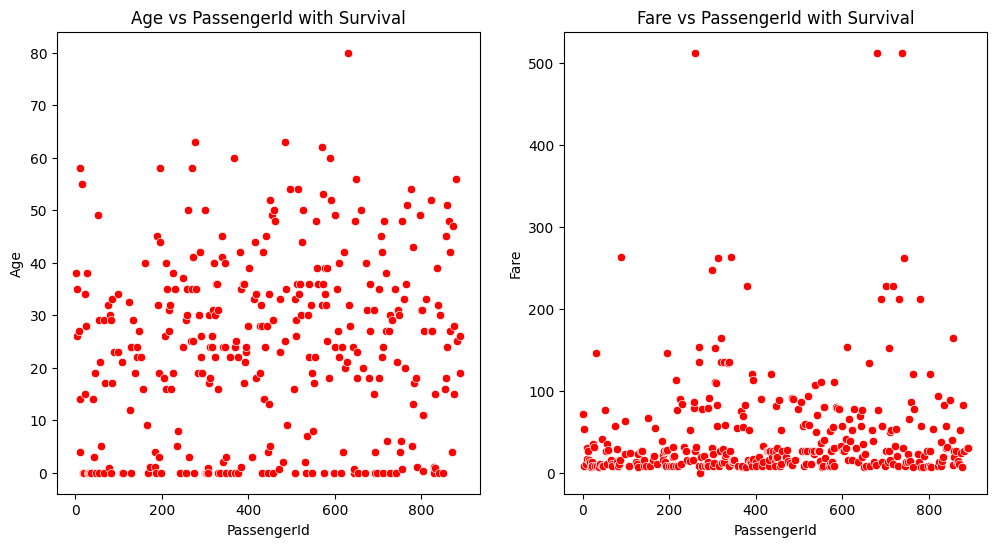

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns

train_data = file_names[0][1].copy()
train_data = train_data[train_data['Survived']==1]

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
#plt.figure(figsize=(6, 4))
sns.scatterplot(data=train_data, x='PassengerId', y='Age', color='Red', ax=axes[0])

axes[0].set_title('Age vs PassengerId with Survival')
axes[0].set_xlabel('PassengerId')
axes[0].set_ylabel('Age')
#plt.show()

#plt.figure(figsize=(6, 4))
sns.scatterplot(data=train_data, x='PassengerId', y='Fare', color='Red', ax=axes[1])

axes[1].set_title('Fare vs PassengerId with Survival')
axes[1].set_xlabel('PassengerId')
axes[1].set_ylabel('Fare')

'''
train_data["family"] = train_data["SibSp"] + train_data["Parch"] + 1
sns.scatterplot(data=train_data, x='PassengerId', y='family', color='Red', ax=axes[1][0])

axes[1][0].set_title('Family vs PassengerId by Survival Status')
axes[1][0].set_xlabel('PassengerId')
axes[1][0].set_ylabel('Family')
'''

plt.show()


In [48]:
from sklearn.cluster import KMeans
import numpy as np

train_data = file_names[0][1].copy()
print(len(train_data))

# K-mean for Age
survived_ages = train_data[train_data['Survived'] == 1]['Age'].dropna()
survived_ages_reshaped = survived_ages.dropna().values.reshape(-1, 1)

kmeans_age = KMeans(n_clusters=3, random_state=0).fit(survived_ages_reshaped)
train_data.loc[train_data['Survived'] == 1, 'Age_Group'] = kmeans_age.labels_

# K-mean for Fare
survived_fare = train_data[train_data['Survived'] == 1]['Fare'].dropna()
survived_fare_reshaped = survived_fare.dropna().values.reshape(-1, 1)

kmeans_fare = KMeans(n_clusters=4, random_state=0).fit(survived_fare_reshaped)
train_data.loc[train_data['Survived'] == 1, 'Fare_Group'] = kmeans_fare.labels_

for i in range(3):
    group_range_age = survived_ages_reshaped[kmeans_age.labels_ == i]
    print(f"Age Group {i+1} Range：{group_range_age.min()} - {group_range_age.max()}")

for i in range(4):
    group_range_fare = survived_fare_reshaped[kmeans_fare.labels_ == i]
    print(f"Fare Group {i+1} Range：{group_range_fare.min()} - {group_range_fare.max()}")


889
Age Group 1 Range：0.0 - 13.0
Age Group 2 Range：35.0 - 80.0
Age Group 3 Range：14.0 - 34.0
Fare Group 1 Range：0.0 - 41.5792
Fare Group 2 Range：133.65 - 263.0
Fare Group 3 Range：512.3292 - 512.3292
Fare Group 4 Range：49.5 - 120.0


In [49]:
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder

for i, [name, df] in enumerate(file_names):
  print('★',name)

  # feature 1
  scaler = MinMaxScaler()
  df['Fare'] = scaler.fit_transform(df[['Fare']])

  # feature 2
  select_features = ['Sex', 'Age']
  df['Sex_Age'] = df['Sex'].astype(str) + '_' + df['Age'].astype(str)

  # feature 3
  df['Age_Fare'] = df['Age'] * df['Fare']
  df['Age_Fare_sum'] = df['Age'] + df['Fare']

  bins = [0, 14, 35, float('inf')]
  labels = ['0-13', '14-34', '35+']
  df['Age_Group'] = pd.cut(df['Age'], bins=bins, labels=labels, right=False)

  # feature 4
  bins = [0, 49.5, 133.65, 265, float('inf')]
  labels = ['low price', 'mid price', 'high price', 'top price']
  df['Fare_Group'] = pd.cut(df['Age'], bins=bins, labels=labels, right=False)

  # feature 5
  df['Ticket_Count'] = df.groupby('Ticket')['Ticket'].transform('count')

  # feature 6
  df['Fare_Embarked'] = df['Fare'] * df['Embarked'].map({'C': 1, 'Q': 2, 'S': 3})

  # feature 7
  df['SibSp_Parch'] = df['SibSp'] + df['Parch']

  print(df.head())

print(file_names[0][1].columns)

★ train.csv
   PassengerId  Survived  Pclass     Sex   Age  SibSp  Parch  \
0            1         0       3    male  22.0      1      0   
1            2         1       1  female  38.0      1      0   
2            3         1       3  female  26.0      0      0   
3            4         1       1  female  35.0      1      0   
4            5         0       3    male  35.0      0      0   

             Ticket      Fare Embarked      Sex_Age  Age_Fare  Age_Fare_sum  \
0         A/5 21171  0.014151        S    male_22.0  0.311323     22.014151   
1          PC 17599  0.139136        C  female_38.0  5.287158     38.139136   
2  STON/O2. 3101282  0.015469        S  female_26.0  0.402183     26.015469   
3            113803  0.103644        S  female_35.0  3.627550     35.103644   
4            373450  0.015713        S    male_35.0  0.549939     35.015713   

  Age_Group Fare_Group  Ticket_Count  Fare_Embarked  SibSp_Parch  
0     14-34  low price             1       0.042453          

In [50]:
from uuid import NAMESPACE_OID
from sklearn.preprocessing import LabelEncoder

file_names_drop = []
for i, [name, df] in enumerate(file_names):
  print('★',name)

  # text to label
  Sex_encoder = LabelEncoder()
  df['Sex'] = Sex_encoder.fit_transform(df['Sex'])
  Sex_Age_encoder = LabelEncoder()
  df['Sex_Age'] = Sex_Age_encoder.fit_transform(df['Sex_Age'])
  Embarked_encoder = LabelEncoder()
  df['Embarked'] = Embarked_encoder.fit_transform(df['Embarked'])
  Ticket_encoder = LabelEncoder()
  df['Ticket'] = Ticket_encoder.fit_transform(df['Ticket'])
  Age_G_encoder = LabelEncoder()
  df['Age_Group'] = Age_G_encoder.fit_transform(df['Age_Group'])
  Fare_G_encoder = LabelEncoder()
  df['Fare_Group'] = Fare_G_encoder.fit_transform(df['Fare_Group'])


  print(df.head())

★ train.csv
   PassengerId  Survived  Pclass  Sex   Age  SibSp  Parch  Ticket      Fare  \
0            1         0       3    1  22.0      1      0     522  0.014151   
1            2         1       1    0  38.0      1      0     595  0.139136   
2            3         1       3    0  26.0      0      0     668  0.015469   
3            4         1       1    0  35.0      1      0      48  0.103644   
4            5         0       3    1  35.0      0      0     471  0.015713   

   Embarked  Sex_Age  Age_Fare  Age_Fare_sum  Age_Group  Fare_Group  \
0         2       82  0.311323     22.014151          1           0   
1         0       35  5.287158     38.139136          2           0   
2         2       20  0.402183     26.015469          1           0   
3         2       32  3.627550     35.103644          2           0   
4         2      102  0.549939     35.015713          2           0   

   Ticket_Count  Fare_Embarked  SibSp_Parch  
0             1       0.042453          

In [102]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier

train_data = file_names[0][1]
test_data = file_names[1][1]
submission_data = pd.read_csv(file_path + 'submission.csv')

'''
select = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch',
       'Ticket', 'Fare', 'Embarked', 'Sex_Age', 'Age_Fare', 'Age_Fare_sum',
       'Age_Group', 'Fare_Group', 'Ticket_Count', 'Fare_Embarked',
       'SibSp_Parch']
'''
select = ['Pclass',
       'Ticket', 'Embarked', 'Sex_Age', 'Age_Fare',
       'Age_Group', 'Ticket_Count', 'Fare_Embarked',
       'SibSp_Parch']

X = train_data[select]
y = train_data['Survived']
X_test = test_data[select]

#rf_model  = RandomForestClassifier(n_estimators=100, random_state=2, max_depth=5)
gbdt_model = XGBClassifier(n_estimators=200, random_state=2, max_depth=5,
              learning_rate=0.1, use_label_encoder=False, eval_metric='logloss')

#rf_model.fit(X, y)
gbdt_model.fit(X, y)

'''
Model = VotingClassifier(
    estimators=[('rf', rf_model), ('gbdt', gbdt_model)],
    voting='soft'
)

Model.fit(X, y)

y_pred = Model.predict(X_test)
'''


y_pred = gbdt_model.predict(X_test)

submission_target = submission_data['Survived']
accuracy = accuracy_score(submission_target, y_pred)

feature_importances = gbdt_model.feature_importances_

print(f"Accuracy: {accuracy:.4f}")



#r.append((subset, accuracy, feature_importances))

# fine the best accuracy and features
#best_features, best_accuracy, feature_importances = max(r, key=lambda x: x[1])

for feature, importance in zip(select, feature_importances):
    print(f"{feature}: {importance:.4f}")



/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [15:31:44] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy: 0.5909
Pclass: 0.3350
Ticket: 0.0583
Embarked: 0.0510
Sex_Age: 0.1985
Age_Fare: 0.0585
Age_Group: 0.1029
Ticket_Count: 0.0766
Fare_Embarked: 0.0578
SibSp_Parch: 0.0613


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score
from itertools import combinations
from sklearn.metrics import accuracy_score


train_data = file_names[0][1]
test_data = file_names[1][1]
submission_data = pd.read_csv(file_path + 'submission.csv')

'''
select = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch',
       'Ticket', 'Fare', 'Embarked', 'Sex_Age', 'Age_Fare', 'Age_Fare_sum',
       'Ticket_Count', 'Fare_Embarked', 'SibSp_Parch']
'''
select = ['Pclass', 'Sex', 'Age', 'Parch',
       'Ticket', 'Fare', 'Sex_Age', 'Age_Fare', 'Age_Fare_sum',
       'Ticket_Count', 'Fare_Embarked', 'SibSp_Parch']

r = []

for i in range(1, len(select) + 1):
    for subset in combinations(select, i):

        #X = pd.get_dummies(train_data[list(subset)])
        X = train_data[list(subset)]
        #X = pd.get_dummies(df[select])
        y = train_data['Survived']
        #X_test = pd.get_dummies(test_data[list(subset)])
        X_test = test_data[list(subset)]

        #X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2)
        Model = RandomForestClassifier(n_estimators=100, random_state=2, max_depth=3)

        Model.fit(X, y)
        y_pred = Model.predict(X_test)

        submission_target = submission_data['Survived']
        accuracy = accuracy_score(submission_target, y_pred)

        feature_importances = Model.feature_importances_
        r.append((subset, accuracy, feature_importances))

# fine the best accuracy and features
best_features, best_accuracy, feature_importances = max(r, key=lambda x: x[1])
print(f"Best Features: {best_features}")
print(f"Best Accuracy: {best_accuracy:.4f}")

for feature, importance in zip(best_features, feature_importances):
    print(f"{feature}: {importance:.4f}")


Best Features: ('Pclass', 'Sex', 'Fare', 'Age_Fare', 'SibSp_Parch')
Best Accuracy: 0.7895
Pclass: 0.1668
Sex: 0.5687
Fare: 0.1289
Age_Fare: 0.0699
SibSp_Parch: 0.0656


In [43]:
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import accuracy_score

# 多個隨機森林做集成學習，round 0.78~0.75
train_data = file_names[0][1]
test_data = file_names[1][1]
submission_data = pd.read_csv(file_path + 'submission.csv')

select = ['Pclass', 'Sex',
       'Ticket', 'Age_Fare',
       'Fare_Embarked', 'SibSp_Parch']

select_features1 = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch',
       'Ticket', 'Fare', 'Embarked', 'Sex_Age', 'Age_Fare', 'Age_Fare_sum',
       'Age_Doubler', 'Ticket_Count', 'Fare_Embarked', 'SibSp_Parch',
       'Age_Group']

select_features2 = ['Pclass', 'Sex', 'Age',
       'Ticket', 'Fare', 'Sex_Age', 'Age_Fare', 'Age_Fare_sum',
       'Ticket_Count', 'Fare_Embarked', 'SibSp_Parch']
select_features3 = ['Pclass', 'Sex', 'Age',
       'Ticket', 'Fare', 'Sex_Age', 'Age_Fare', 'Age_Fare_sum',
       'Fare_Embarked', 'SibSp_Parch']

X1 = pd.get_dummies(train_data[select_features1])
X2 = pd.get_dummies(train_data[select_features2])
X3 = pd.get_dummies(train_data[select_features3])
y = train_data['Survived']

X_test1 = pd.get_dummies(test_data[select_features1])
X_test2 = pd.get_dummies(test_data[select_features2])
X_test3 = pd.get_dummies(test_data[select_features3])


rf1 = RandomForestClassifier(n_estimators=300, max_depth=3, random_state=10)
rf2 = RandomForestClassifier(n_estimators=200, max_depth=5, random_state=10)
rf3 = RandomForestClassifier(n_estimators=300, max_depth=7, random_state=10)


rf1.fit(X1, y)
rf2.fit(X2, y)
rf3.fit(X3, y)

Model = VotingClassifier(
    estimators=[('rf1', rf1), ('rf2', rf2), ('rf3', rf3)],
    voting='soft'  # 'soft' for probabilities; 'hard' for majority voting
)

y_pred1 = rf1.predict_proba(X_test1)
y_pred2 = rf2.predict_proba(X_test2)
y_pred3 = rf3.predict_proba(X_test3)

Model.fit(pd.concat([X1], axis=1), y)
y_pred = Model.predict(pd.concat([X_test1], axis=1))



submission_target = submission_data['Survived']
accuracy = accuracy_score(submission_target, y_pred)
print(f"模型對 submission.csv 的準確度: {accuracy:.4f}")

print('\n select_features1')
feature_importances = rf1.feature_importances_
for feature, importance in zip(select_features1, feature_importances):
    print(f"{feature}: {importance:.4f}")

print('\n select_features2')
feature_importances = rf2.feature_importances_
for feature, importance in zip(select_features2, feature_importances):
    print(f"{feature}: {importance:.4f}")

print('\n select_features3')
feature_importances = rf3.feature_importances_
for feature, importance in zip(select_features3, feature_importances):
    print(f"{feature}: {importance:.4f}")



模型對 submission.csv 的準確度: 0.7775

 select_features1
Pclass: 0.1321
Sex: 0.4656
Ticket: 0.0834
Fare: 0.1283
Age_Fare: 0.0362
Ticket_Count: 0.0330
Fare_Embarked: 0.0586
SibSp_Parch: 0.0465
Age_Doubler: 0.0164

 select_features2
Pclass: 0.0891
Sex: 0.2027
Age: 0.0249
Ticket: 0.0791
Fare: 0.0815
Sex_Age: 0.2991
Age_Fare: 0.0492
Age_Fare_sum: 0.0393
Ticket_Count: 0.0393
Fare_Embarked: 0.0543
SibSp_Parch: 0.0413

 select_features3
Pclass: 0.0796
Sex: 0.1844
Age: 0.0435
Ticket: 0.1054
Fare: 0.0957
Sex_Age: 0.2444
Age_Fare: 0.0687
Age_Fare_sum: 0.0621
Fare_Embarked: 0.0667
SibSp_Parch: 0.0496


In [16]:
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier


train_data = file_names[0][1]
test_data = file_names[1][1]
submission_data = pd.read_csv(file_path + 'submission.csv')

#select = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Embarked']
select = ['Pclass', 'Sex', 'Age', 'Parch',
       'Ticket', 'Fare', 'Sex_Age', 'Age_Fare', 'Age_Fare_sum',
       'Ticket_Count', 'Fare_Embarked', 'SibSp_Parch']
select1 = ['Pclass', 'Sex', 'Parch',
       'Ticket', 'Fare', 'Sex_Age', 'Age_Fare', 'Age_Fare_sum',
       'Ticket_Count', 'Fare_Embarked', 'SibSp_Parch']
select2 = ['Pclass', 'Age', 'Parch',
       'Ticket', 'Fare', 'Sex_Age', 'Age_Fare', 'Age_Fare_sum',
       'Ticket_Count', 'Fare_Embarked', 'SibSp_Parch']


X = pd.get_dummies(train_data[list(select)])
X1 = pd.get_dummies(train_data[list(select1)])
X2 = pd.get_dummies(train_data[list(select2)])
y = train_data['Survived']
X_test1 = pd.get_dummies(test_data[list(select1)])
X_test2 = pd.get_dummies(test_data[list(select2)])

rf_model = RandomForestClassifier(n_estimators=200, random_state=2, max_depth=3)
dt_model = DecisionTreeClassifier(max_depth=7, random_state=2)

rf_model.fit(X1, y)
dt_model.fit(X2, y)

y_pred_rf = rf_model.predict_proba(X_test1)[:, 1]
y_pred_dt = dt_model.predict_proba(X_test2)[:, 1]


# 最終加權結果 (可以調整權重 0.5 和 0.5)
y_pred = (0.5 * y_pred_rf + 0.5 * y_pred_dt) > 0.5


submission_target = submission_data['Survived']
accuracy = accuracy_score(submission_target, y_pred)
print(f"模型對 submission.csv 的準確度: {accuracy:.4f}")


print('\n RandomForest')
feature_importances = rf_model.feature_importances_
for feature, importance in zip(select1, feature_importances):
    print(f"{feature}: {importance:.4f}")

print('\n DecisionTree')
feature_importances = dt_model.feature_importances_
for feature, importance in zip(select2, feature_importances):
    print(f"{feature}: {importance:.4f}")


模型對 submission.csv 的準確度: 0.6555

 RandomForest
Pclass: 0.1005
Sex: 0.2551
Parch: 0.0104
Ticket: 0.0668
Fare: 0.0787
Sex_Age: 0.3332
Age_Fare: 0.0374
Age_Fare_sum: 0.0131
Ticket_Count: 0.0334
Fare_Embarked: 0.0431
SibSp_Parch: 0.0285

 DecisionTree
Pclass: 0.1044
Age: 0.0155
Parch: 0.0211
Ticket: 0.1190
Fare: 0.0407
Sex_Age: 0.4411
Age_Fare: 0.0552
Age_Fare_sum: 0.0551
Ticket_Count: 0.0098
Fare_Embarked: 0.0889
SibSp_Parch: 0.0492


In [ ]:
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, precision_score, recall_score
from itertools import combinations

train_data = file_names_drop[0][1]
test_data = file_names_drop[1][1]
submission_data = pd.read_csv(file_path + 'submission.csv')

# 使用必要的特徵進行建模
select_features = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch',
       'Ticket', 'Fare', 'Embarked', 'Family', 'Sex_Age', 'Age_Fare',
       'Ticket_Count']  # 替換成你要使用的特徵

y = train_data['Survived']
submission_target = submission_data['Survived']

# 設定模型和記錄最佳特徵
best_accuracy = 0
best_features = []

# 將特徵隨機組合進行模型訓練
for i in range(1, len(select_features) + 1):
    feature_combinations = list(combinations(select_features, i))

    for subset in feature_combinations:
        X_train = pd.get_dummies(train_data[list(subset)])
        X_test = pd.get_dummies(test_data[list(subset)])

        # 初始化模型
        rf_model = RandomForestClassifier(n_estimators=200, random_state=2, max_depth=3)
        #lr_model = LogisticRegression(random_state=2, max_iter=500)
        nb_model = GaussianNB()

        ensemble_model = VotingClassifier(
            estimators=[('rf', rf_model), ('nb', nb_model)],
            voting='soft'
        )
        '''
        ensemble_model = VotingClassifier(
            estimators=[('rf', rf_model), ('lr', lr_model), ('nb', nb_model)],
            voting='soft'
        )
        '''
        # 訓練集成模型
        ensemble_model.fit(X_train, y)
        y_pred = ensemble_model.predict(X_test)

        # 計算準確度
        accuracy = accuracy_score(submission_target, y_pred)

        # 如果此組合表現最佳，更新最佳組合和準確率
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_features = subset

print(f"最佳特徵組合: {best_features}")
print(f"最佳準確度: {best_accuracy:.4f}")